# CSE185 Lab 6 Documentation - scRNA-seq

In this lab, we will analyze scRNA-seq data of human pancreatic cells which were derived from stem cells. By analyzing single-cell data from multiple stages across the differentiation process all the way from stem cells to pancreatic islets, we can also learn about the genes that go up and down across the different stages of development.

We will look at single-cell RNA-seq data generated using 10X Genomics technology. Data is taken from the paper: [Functional, metabolic and transcriptional maturation of human pancreatic islets derived from stem cells](https://www.nature.com/articles/s41587-022-01219-z). The paper produces data for many stages of differentiation of stem cells into pancreas cells, and after those cells are transplanted into mice. We will focus on just three of the time points.

In [ ]:
%pip install scanpy harmonypy leidenalg

In [78]:
# Add install path to sys.path to get imports to work
import sys
import os
sys.path.append(os.environ["HOME"]+"/.local/lib/python3.9/site-packages")

import scanpy as sc, anndata as ad
import harmonypy
import leidenalg

In [79]:
## 1. Loading datasets into anndata object and printing out helpful info

import os
import scanpy as sc, anndata as ad

DATADIR=os.environ["HOME"]+"/public/lab6"
dsets = ["GSM5114461_S6_A11", "GSM5114464_S7_D20", "GSM5114474_M3_E7"]
adatas = {}
for ds in dsets:
    print(ds)
    adatas[ds] = sc.read_10x_mtx(DATADIR, prefix=ds+"_", cache=True)
combined = ad.concat(adatas, label="dataset")

combined.obs_names_make_unique()

combined # will print out the dimensions of the combined dataset loaded


GSM5114461_S6_A11
GSM5114464_S7_D20
GSM5114474_M3_E7


/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 12357 × 20621
    obs: 'dataset'

In [80]:
adatas["GSM5114461_S6_A11"]# will print out dimensions of the individual datasets
                           # repeat with each dataset below
    

AnnData object with n_obs × n_vars = 4793 × 20621
    var: 'gene_ids', 'feature_types'

In [81]:
adatas["GSM5114464_S7_D20"]


AnnData object with n_obs × n_vars = 4910 × 20621
    var: 'gene_ids', 'feature_types'

In [82]:
adatas["GSM5114474_M3_E7"]


AnnData object with n_obs × n_vars = 2654 × 20621
    var: 'gene_ids', 'feature_types'

In [83]:
combined.obs # will print out info about each cell. 
             # You should see a "dataset" column indicating which dataset each cell came from


,dataset
AAACCTGAGAAGGACA,GSM5114461_S6_A11
AAACCTGAGTAAGTAC,GSM5114461_S6_A11
AAACCTGGTCCCGACA,GSM5114461_S6_A11
AAACCTGTCCTAAGTG,GSM5114461_S6_A11
AAACCTGTCGCCTGTT,GSM5114461_S6_A11
...,...
TTTGTCAAGCGTCTAT,GSM5114474_M3_E7
TTTGTCAAGTCGTACT,GSM5114474_M3_E7
TTTGTCAGTCTGATTG,GSM5114474_M3_E7
TTTGTCATCCCGGATG,GSM5114474_M3_E7


In [84]:
## 2. Filter out cells with low reads and little genes expressed, and genes that are detected
##    in less than 5 cells or have low counts. 

sc.pp.filter_cells(combined, min_counts=1000)
sc.pp.filter_cells(combined, min_genes=200)

sc.pp.filter_genes(combined, min_cells=5)
sc.pp.filter_genes(combined, min_counts=15)

combined.n_obs # prints number of cells

10133

In [85]:
combined.n_vars # prints number of genes


15779

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


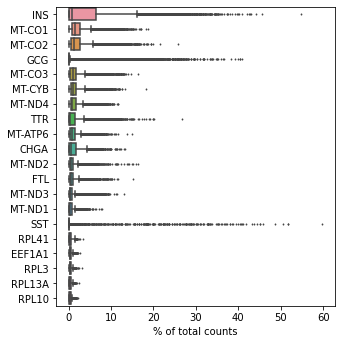

In [86]:
## 3. Plot most highly expressed genes in combined dataset

sc.pl.highest_expr_genes(combined, n_top=20)

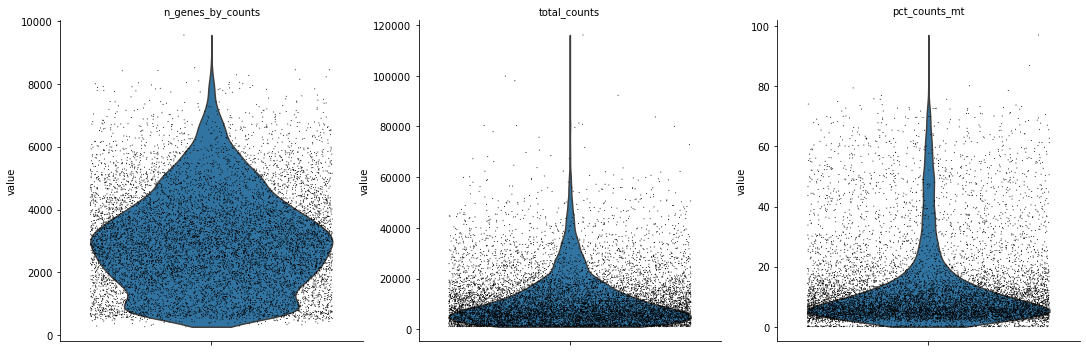

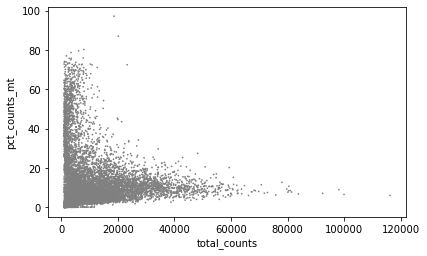

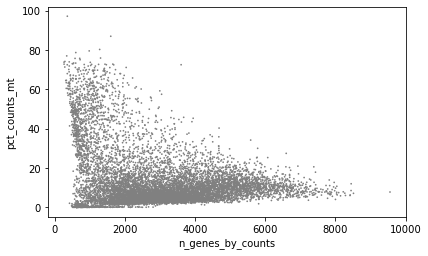

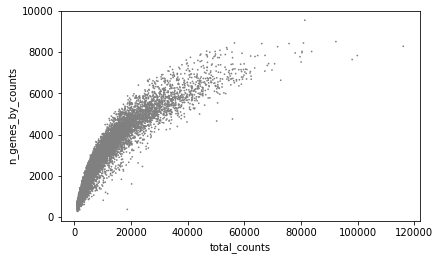

In [87]:
## Determine the percent of counts in each cell that are from mitochondrial genes and create violin and scatter plots 

combined.var["mt"] = combined.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    combined, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

sc.pl.violin(
    combined,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,save=".png"
)

sc.pl.scatter(combined, x="total_counts", y="pct_counts_mt",save="_counts_mt.png")
sc.pl.scatter(combined, x="n_genes_by_counts", y="pct_counts_mt",save="_genes_mt.png")
sc.pl.scatter(combined, x="total_counts", y="n_genes_by_counts",save="_counts_genes.png")


In [88]:
## Filter out cells with high mitochondrial gene percentage and other outliers

adata_filt = combined[(combined.obs.pct_counts_mt < 25) &
                    (combined.obs.total_counts < 60000) &
                    (combined.obs.n_genes_by_counts < 7500), :]


adata_filt.n_obs # prints number of cells


8670

In [89]:
adata_filt.n_vars # prints number of genes


15779

In [90]:
sc.pp.normalize_per_cell(adata_filt, counts_per_cell_after=1e4) # normalize to 10,000 reads/cell
sc.pp.log1p(adata_filt) # log transform


/opt/conda/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [91]:
## 4. Identifying highly variable genes in each dataset

sc.pp.highly_variable_genes(adata_filt, batch_key="dataset", n_top_genes=500)

adata_filt.var.nlargest(5,"dispersions_norm") # prints out 5 most highly variable genes

,n_cells,n_counts,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
PPY,1148,9090.0,False,1148,0.897069,88.670680,9090.0,True,0.641330,5.204456,12.726539,3,True
NPY,432,6225.0,False,432,0.614329,95.736702,6225.0,True,0.299428,5.028283,12.345587,3,True
LYZ,666,6956.0,False,666,0.686470,93.427415,6956.0,True,0.509725,4.529962,9.732418,3,True
KRT17,204,1585.0,False,204,0.156420,97.986776,1585.0,True,0.160272,3.850699,8.311301,3,True
NTS,464,5101.0,False,464,0.503405,95.420902,5101.0,True,0.259135,3.492364,8.257049,3,True


In [92]:
# We'll manually add these genes to make sure they stay in our 
# dataset for the analyses below.
genes = ["GCG", "TTR",  "IAPP",  "GHRL", "PPY", "COL3A1",
    "CPA1", "CLPS", "REG1A", "CTRB1", "CTRB2", "PRSS2", "CPA2", "KRT19", "INS","SST","CELA3A", "VTCN1"]

adata_var = adata_filt[:, (adata_filt.var.index.isin(genes) | adata_filt.var["highly_variable"])]

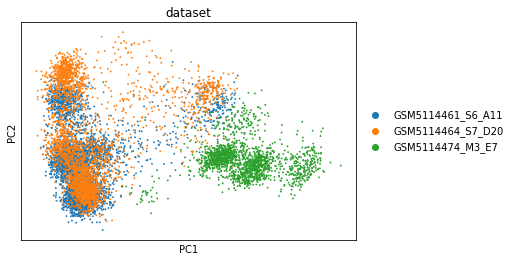

In [93]:
## 5. Plot PCA along first two PC's to visualize batch effects
sc.pp.pca(adata_var, n_comps=50)
sc.pl.pca(adata_var, color="dataset", save=".png")

2024-05-15 08:23:00,569 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-15 08:25:26,875 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-15 08:25:27,205 - harmonypy - INFO - Iteration 1 of 10
2024-05-15 08:25:43,201 - harmonypy - INFO - Iteration 2 of 10
2024-05-15 08:25:57,904 - harmonypy - INFO - Iteration 3 of 10
2024-05-15 08:26:12,606 - harmonypy - INFO - Converged after 3 iterations


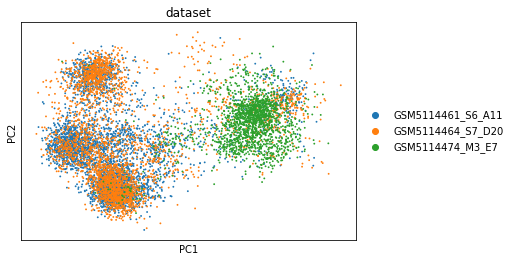

In [94]:
## Use Harmony to adjust PCA embeddings and control batch effects. Plot new PCA

# Import the "external" library
import scanpy.external as sce

# Run harmony using suggested params from the paper
sce.pp.harmony_integrate(adata_var, 'dataset', theta=2, nclust=50,  max_iter_harmony=10,  max_iter_kmeans=10)

# Reset the original PCs to those computed by Harmony
adata_var.obsm['X_pca'] = adata_var.obsm['X_pca_harmony']

# Replot PCA using new PCs from Harmony
sc.pl.pca(adata_var, color="dataset", save="_harmony.png")

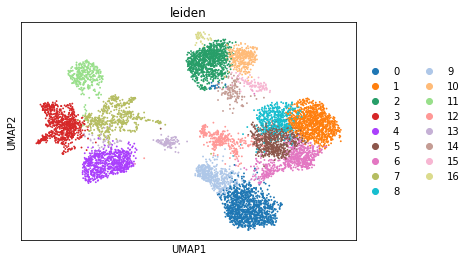

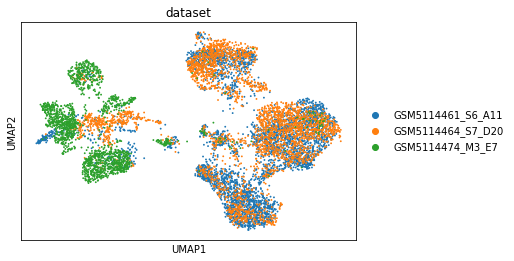

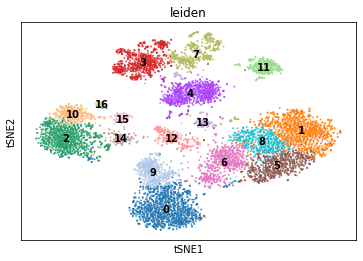

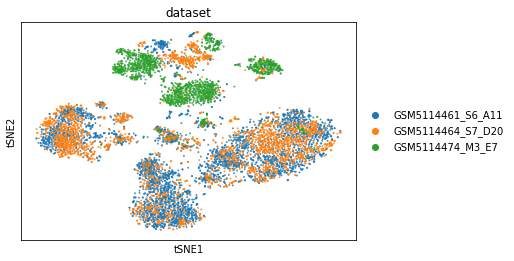

In [96]:
# 6. Perform clusters on our data and visualize using t-SNE and UMAP plots

sc.pp.neighbors(adata_var, n_neighbors=10, n_pcs=50) # computes neighborhood graphs. Needed to run clustering.
sc.tl.leiden(adata_var) # clusters cells based on expression profiles. This is needed to color cells by cluster.

# UMAP
sc.tl.umap(adata_var) # compute UMAP embedding
sc.pl.umap(adata_var, color="leiden", save="_leiden.png") # make the UMAP plot, coloring cells by cluster
sc.pl.umap(adata_var, color="dataset",save="_dataset.png") # make the UMAP plot, coloring cells by dataset

# tSNE
sc.tl.tsne(adata_var, n_pcs=50, perplexity=30)
sc.pl.tsne(adata_var, color='leiden', legend_loc='on data', legend_fontsize=10, alpha=0.8, size=15, save="_leiden.png")
sc.pl.tsne(adata_var, color='dataset', legend_loc='right margin', legend_fontsize=10, alpha=0.8, size=15, save="_dataset.png")



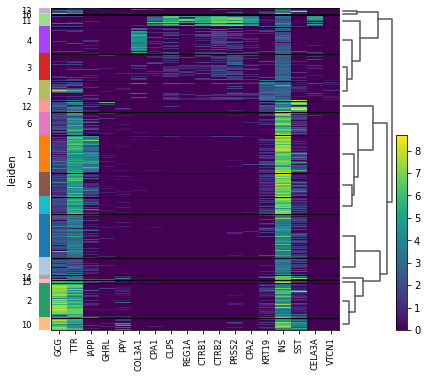

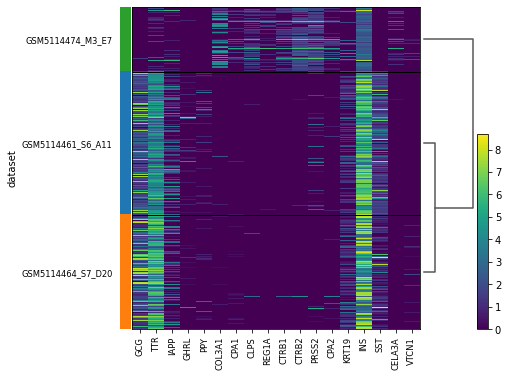

In [101]:
## heatmap of expression of genes by cluster and by dataset

genes = ["GCG", "TTR",  "IAPP",  "GHRL", "PPY", "COL3A1",
    "CPA1", "CLPS", "REG1A", "CTRB1", "CTRB2", "PRSS2", "CPA2", "KRT19", "INS","SST","CELA3A", "VTCN1"]

sc.pl.heatmap(adata_var, genes, groupby='leiden', dendrogram=True)
sc.pl.heatmap(adata_var, genes, groupby='dataset', dendrogram=True)



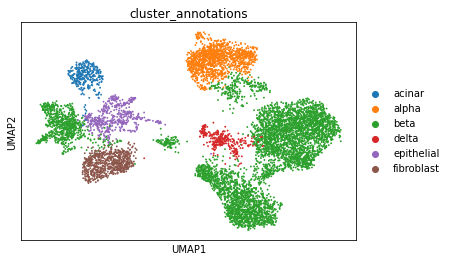

In [99]:
## labeling clusters by cell type based of off gene markers and heatmap expression levels
adata_var.obs["cluster_annotations"] = adata_var.obs["leiden"].map(
    {
        "0": "beta",
        "1": "beta",
        "2": "alpha",
        "3": "beta",
        "4": "fibroblast",
        "5": "beta",
        "6": "beta",
        "7": "epithelial",
        "8": "beta",
        "9": "beta",
        "10": "alpha",
        "11": "acinar",
        "12": "delta",
        "13": "beta",
        "14": "beta",
        "15": "beta",
        "16": "alpha"
    }
)

sc.pl.umap(adata_var, color="cluster_annotations", save="_cluster_annotations.png")

